In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import hanlp
import pickle
import collections
import keras
import pydot
import pydotplus
from pydotplus import graphviz
import time
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


In [2]:
def process_raw_data(file_path,label_cols,text_fea_cols,categorical_fea_cols,numeric_fea_cols,):
    df_raw = pd.read_csv(file_path, header=0, error_bad_lines=False, delimiter='\t', engine='python')    
    df_raw.fillna(value="",inplace=True)
    df_no_user=df_raw.iloc[:,1:]
    
    '''for easy debug'''
    #df_no_user=df_no_user.head(3000)

    labels=df_no_user.iloc[:,label_cols]
    text_fea=df_no_user.iloc[:,text_fea_cols]
    categorical_fea=df_no_user.iloc[:,categorical_fea_cols]
    numeric_fea=df_no_user.iloc[:,numeric_fea_cols]
       
    return df_no_user,labels,text_fea,categorical_fea,numeric_fea
     

In [3]:
def process_numeric_fea(df):
    df.replace('',0,inplace=True)
    '''for log(x),s.t. x>0'''
    for c in df.columns:
        df[c] = df[c].apply(lambda x: 0 if x < 0 else x)
    eps = 0.001 
    df_log = np.log(df+eps)
    x = df_log.values
    x = np.clip(x, -5, 5)
    std_scaler = preprocessing.StandardScaler() 
    x_scaled = std_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled,columns = df.columns.values)     

In [4]:
def split_train_test_data(df,original=True,all_label_cols=None,label_col=None,label_values=None,label_counts=None,repeat_noise_ratio=0.95,sample_noise_ratio=0.95):
    
    print('-'*10+"label counts in all data"+'-'*10)   
    for lc in all_label_cols:
        print('label: ',lc)
        print(df_data.iloc[:,lc].value_counts())
          
    
    data=df.values  
    train_data,test_data=train_test_split(data,test_size=0.1)   
    
    if original==False:
        if len(label_values)!=len(label_counts):
            raise ValueError("list label_values'size isn't equal to list label_counts!")
        if len(np.unique(train_data[:,label_col]))!=len(label_counts):
            raise ValueError("df data dosen't has all label type!")
        
        print('-'*10+"label counts in train data BEFORE sample|repeat|noise"+'-'*10) 
        for lc in all_label_cols:
            print('label: ',lc)
            print(collections.Counter(train_data[:,lc]))
            
        train_data_dict={}
        for i in label_values:
            lv=label_values[i]
            lc=label_counts[i]
            #td=train_data[np.in1d(train_data[:, label_col], lv)]
            td=train_data[np.equal(train_data[:, label_col], lv)]
            td_other=train_data[np.not_equal(train_data[:, label_col], lv)]
            if td.shape[0]>=lc:
                print("label value=",lv," more than need! need=",lc," exist=",td.shape[0])
                noise_counts=math.ceil(lc*(1-sample_noise_ratio))
                noise_idxs=np.random.randint(td_other.shape[0],size=min(noise_counts,td_other.shape[0]))
                noise_td=td_other[noise_idxs,:]
                print("noise data counts=",noise_td.shape[0])
                noise_td[:,label_col]=lv
                               
                sample_counts=lc-noise_td.shape[0]
                sample_idxs=np.random.randint(td.shape[0],size=sample_counts)
                sample_td=td[sample_idxs,:]
                print("sample data counts=",sample_td.shape[0])
               
                merge_td=np.concatenate((sample_td,noise_td),axis=0)
                train_data_dict[lv]=np.asarray(merge_td)
            elif td.shape[0]<lc:
                print("label value=",lv," less than need! need=",lc," exist=",td.shape[0])
                lack_counts=lc-td.shape[0]
                print("lack_counts=",lack_counts)
                noise_counts=math.ceil(lack_counts*(1-repeat_noise_ratio))
                noise_idxs=np.random.randint(td_other.shape[0],size=noise_counts)
                noise_td=td_other[noise_idxs,:]
                print("noise data counts=",noise_td.shape[0])
                noise_td[:,label_col]=lv
                
                repeat_counts=lc-noise_counts
                repeat_times=math.ceil(repeat_counts/td.shape[0])
                repeat_td=np.repeat(td,repeat_times+2,axis=0)
                
                sample_idxs=np.random.randint(repeat_td.shape[0],size=repeat_counts)
                repeat_td=repeat_td[sample_idxs,:]
                print("repeat data counts=",repeat_td.shape[0])
                
                merge_td=np.concatenate((repeat_td,noise_td),axis=0)
                train_data_dict[lv]=np.asarray(merge_td)
                
        train_data=np.concatenate(list(train_data_dict.values()),axis=0)
        print('-'*10+"label counts in train data AFTER sample|repeat|noise"+'-'*10) 
        for lc in all_label_cols:
            print('label: ',lc)
            print(collections.Counter(train_data[:,lc]))
    
    print("train_data.shape=",train_data.shape)
    print('-'*10+"splited data counts"+'-'*10)   
    print('train:',train_data.shape)
    print('test:',test_data.shape)
    
    return train_data,test_data


In [5]:
class Custom_Loss(tf.keras.losses.Loss):
    def __init__(self,weights):
        super().__init__()
        self.weights=weights
    
    def call(self,y_true,y_pred):
        log_y_pred_cost = tf.math.log(y_pred[0])
        log_y_pred_recharge = tf.math.log(y_pred[1])
        y_true_cost = y_true[0]
        y_true_recharge= y_true[1]
       
        entroy_cost = -tf.math.multiply_no_nan(x=log_y_pred_cost, y=y_true_cost)
        loss_cost=tf.reduce_mean(tf.reduce_sum(entroy_cost))  
        
        entroy_recharge = -tf.math.multiply_no_nan(x=log_y_pred_recharge, y=y_true_recharge)
        loss_recharge=tf.reduce_mean(tf.reduce_sum(entroy_recharge))  
        
        loss_1=tf.math.multiply(loss_cost, self.weights)
        loss_2=tf.math.multiply(loss_recharge, 1-self.weights)
        
        return loss_1+loss_2

In [6]:
def create_multi_task_learning_model(input_size):
   
    inputs=tf.keras.layers.Input(shape=(input_size,),dtype=tf.float32,name='numeric_inputs')
    outputs=tf.keras.layers.BatchNormalization()(inputs)
    outputs=tf.keras.layers.Dense(100, activation='relu')(outputs)
    outputs=tf.keras.layers.BatchNormalization()(outputs)
    
    outputs=tf.keras.layers.Dense(60, activation='relu')(outputs)
    outputs=tf.keras.layers.BatchNormalization()(outputs)
    
    outputs_cost=tf.keras.layers.Dense(20, activation='relu')(outputs)
    outputs_cost=tf.keras.layers.BatchNormalization()(outputs_cost)
    outputs_cost=tf.keras.layers.Dense(3, activation='softmax',name='outputs_cost')(outputs_cost)
    
    outputs_recharge=tf.keras.layers.Dense(20, activation='relu')(outputs)
    outputs_recharge=tf.keras.layers.BatchNormalization()(outputs_recharge)
    outputs_recharge=tf.keras.layers.Dense(3, activation='softmax',name='outputs_recharge')(outputs_recharge)
    
    model = Model(inputs=[inputs], outputs=[outputs_cost,outputs_recharge])
    
    
    model.loss_weights = tf.Variable(0.5,
                                     name='loss_weights',
                                     trainable=True,
                                     dtype=tf.float32,
                                     constraint=lambda z: tf.clip_by_value(z, 0, 1))
    
    
    
    model.compile(optimizer='adam',loss=Custom_Loss(model.loss_weights),metrics=['accuracy'])
    
    model.summary()
    tf.keras.utils.plot_model(model, to_file='../model/model_6.2.png',show_shapes=True,show_dtype=True,show_layer_activations=True)
    
    return model
        

In [7]:
def fit_batch(model):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      verbose=1,
                                                      patience=5,
                                                      restore_best_weights=True)
    
    start = time.time()
    
    #checkpoint = keras.callbacks.ModelCheckpoint('../history/checkpoint_{epoch:02d}', save_freq='epoch')
    
    history =model.fit(x=train_numeric_fea,
                       y=[train_cost_categorized_label,train_recharge_categorized_label], 
                       validation_split=0.1,
                       epochs=50,
                       batch_size=32,
                       #callbacks=[checkpoint],
                       verbose=1)
    print(f'Training time: {time.time() - start}\n')
    return history


In [8]:
def plot_multitask_accuracies(training_history):
    
    plt.plot(range(len(history.history['outputs_cost_accuracy'])), history.history['outputs_cost_accuracy'], c='r', label='Cost')
    plt.plot(range(len(history.history['outputs_recharge_accuracy'])), history.history['outputs_recharge_accuracy'], c='b', label='Recharge')

    plt.plot(range(len(history.history['val_outputs_cost_accuracy'])), history.history['val_outputs_cost_accuracy'], c='r',linestyle='dashed', label='Val-Cost')
    plt.plot(range(len(history.history['val_outputs_recharge_accuracy'])), history.history['val_outputs_recharge_accuracy'], c='b', linestyle='dashed',  label='Val-Recharge')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    
    plt.plot(range(len(history.history['outputs_cost_loss'])), history.history['outputs_cost_loss'], c='r', label='Cost')
    plt.plot(range(len(history.history['outputs_recharge_loss'])), history.history['outputs_recharge_loss'], c='b', label='Recharge')

    plt.plot(range(len(history.history['val_outputs_cost_loss'])), history.history['val_outputs_cost_loss'], c='r',linestyle='dashed',  label='Val-Cost')
    plt.plot(range(len(history.history['val_outputs_recharge_loss'])), history.history['val_outputs_recharge_loss'], c='b', linestyle='dashed',  label='Val-Recharge')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    


In [9]:
def evaluate_score(y_true,y_pred_prob):
    pred_label=np.asarray([np.argmax(v) for v in y_pred_prob])
    print('accuracy: %.3f' % accuracy_score(y_true, pred_label))
    print('ovr macro auc: %.3f' % roc_auc_score(y_true, y_pred_prob,multi_class='ovo',average='macro')) #注意这里是prob
    print('ovo macro auc: %.3f' % roc_auc_score(y_true, y_pred_prob, multi_class='ovr',average='macro')) #注意这里是prob
    print('ovr weighted auc: %.3f' % roc_auc_score(y_true, y_pred_prob,multi_class='ovo',average='weighted')) #注意这里是prob
    print('ovo weighted auc: %.3f' % roc_auc_score(y_true, y_pred_prob, multi_class='ovr',average='weighted')) #注意这里是prob
    print('micro precision: %.3f' % precision_score(y_true, pred_label,average='micro'))
    print('macro precision: %.3f' % precision_score(y_true, pred_label,average='macro'))
    print('weighted precision: %.3f' % precision_score(y_true, pred_label,average='weighted'))
    print('micro recall: %.3f' % recall_score(y_true, pred_label,average='micro'))
    print('macro recall: %.3f' % recall_score(y_true, pred_label,average='macro'))
    print('weighted recall: %.3f' % recall_score(y_true, pred_label,average='weighted'))

In [10]:

print('*'*27+" Multi-Task-Model Begin Running "+'**'*27+"\n\n")

print('-'*40+" load data begin "+'-'*40)
label_cols=[0,1]
cost_label_col=0
recharge_label_col=1
text_fea_cols=[2]
categorical_fea_cols=[3,4,5]
numeric_fea_cols=list(range(6,271))
recharge_label_values=[0,1,2]

'''--tuning params--'''
recharge_label_counts=[100000,200000,400000]
is_raw=True
text_matrix=True
train_epochs=10
repeat_noise_ratio=1
sample_noise_ratio=1
data_file="../data/train_data_nlp_and_number_and_category_and_sentiments_feature_multi_label__extra_large.txt"
'''--tuning params--'''

numeric_input_size=len(numeric_fea_cols)

df_no_user,labels,text_fea,categorical_fea,numeric_fea=process_raw_data(
    file_path=data_file,
    label_cols=label_cols,
    text_fea_cols=text_fea_cols,
    categorical_fea_cols=categorical_fea_cols,
    numeric_fea_cols=numeric_fea_cols
    )

print("df_no_user.shape=",df_no_user.shape)
print("labels.shape=",labels.shape)
print("text_fea.shape=",text_fea.shape)
print("categorical_fea.shape=",categorical_fea.shape)
print("numeric_fea.shape=",numeric_fea.shape)
print(df_no_user.head(1))
print('-'*40+" load data end "+'-'*40)

*************************** Multi-Task-Model Begin Running ******************************************************


---------------------------------------- load data begin ----------------------------------------
df_no_user.shape= (1000000, 271)
labels.shape= (1000000, 2)
text_fea.shape= (1000000, 1)
categorical_fea.shape= (1000000, 3)
numeric_fea.shape= (1000000, 265)
   c_label  r_label                                    problem_content  \
0        2        2  采购员客服发布招聘信息刷新优化#电话联系 设置采购 客服精品刷新 效果不好 建议客户多发帖#...   

   main_belong_loc1  main_belong_cate2 main_city_hierarchy  free_money_avg_1d  \
0              7578               3112                  二线                0.0   

   free_money_avg_3d  free_money_avg_7d  free_money_avg_14d  ...  \
0           0.002022           0.006067            0.013146  ...   

   m_login_counts_60d  sum_senti_score_latest_3month  \
0                   0                       1.184329   

   count_senti_score_latest_3mont  avg_score_latest_3month  \
0  

In [11]:
print('-'*40+" process feature begin "+'-'*40)
df_numeric_fea_scale=process_numeric_fea(numeric_fea)
df_data=pd.concat([labels,df_numeric_fea_scale],axis=1)

if is_raw:
    train_data,test_data=split_train_test_data(df_data,all_label_cols=label_cols,original=True)
else:
    train_data,test_data=split_train_test_data(df_data,all_label_cols=label_cols,original=False,
                                               label_col=recharge_label_col,label_values=recharge_label_values,label_counts=recharge_label_counts,
                                               repeat_noise_ratio=repeat_noise_ratio,sample_noise_ratio=sample_noise_ratio)

print('-'*40+" process feature end "+'-'*40)

---------------------------------------- process feature begin ----------------------------------------
----------label counts in all data----------
label:  0
2    678125
1    196610
0    125265
Name: c_label, dtype: int64
label:  1
2    968061
1     21319
0     10620
Name: r_label, dtype: int64
train_data.shape= (900000, 267)
----------splited data counts----------
train: (900000, 267)
test: (100000, 267)
---------------------------------------- process feature end ----------------------------------------


In [12]:
print('-'*40+" process label and feature begin "+'-'*40)

train_cost_label=train_data[:,0] 
train_recharge_label=train_data[:,1]
train_numeric_fea=train_data[:,2:]
    
test_cost_label=test_data[:,0]
test_recharge_label=test_data[:,1]
test_numeric_fea=test_data[:,2:]
    
    ##此处加上这个是为了解决：Failed to convert a NumPy array to a Tensor (Unsupported object type int).
train_cost_label=np.asarray(train_cost_label).astype('int32')
train_recharge_label=np.asarray(train_recharge_label).astype('int32')
train_numeric_fea=np.asarray(train_numeric_fea).astype('float32') ##float not int !!
    
test_cost_label=np.asarray(test_cost_label).astype('int32')
test_recharge_label=np.asarray(test_recharge_label).astype('int32')
test_numeric_fea=np.asarray(test_numeric_fea).astype('float32') ##float not int !!
    
print("train_cost_label.shape=",train_cost_label.shape)
print("train_recharge_label.shape=",train_recharge_label.shape)
print("train_numeric_fea.shape=",train_numeric_fea.shape)

print("test_cost_label.shape=",test_cost_label.shape)
print("test_recharge_label.shape=",test_recharge_label.shape)
print("test_numeric_fea.shape=",test_numeric_fea.shape)

print('-'*40+" process label and feature end "+'-'*40)


---------------------------------------- process label and feature begin ----------------------------------------
train_cost_label.shape= (900000,)
train_recharge_label.shape= (900000,)
train_numeric_fea.shape= (900000, 265)
test_cost_label.shape= (100000,)
test_recharge_label.shape= (100000,)
test_numeric_fea.shape= (100000, 265)
---------------------------------------- process label and feature end ----------------------------------------


In [13]:
train_cost_categorized_label=tf.keras.utils.to_categorical(train_cost_label,num_classes=3)
train_recharge_categorized_label=tf.keras.utils.to_categorical(train_recharge_label,num_classes=3)

test_cost_categorized_label=tf.keras.utils.to_categorical(test_cost_label,num_classes=3)
test_recharge_categorized_label=tf.keras.utils.to_categorical(test_recharge_label,num_classes=3)

print(train_cost_categorized_label.shape)
print(train_cost_categorized_label[0:2])
print(train_recharge_categorized_label[0:2])

(900000, 3)
[[0. 1. 0.]
 [0. 1. 0.]]
[[0. 0. 1.]
 [0. 0. 1.]]


In [14]:
print('-'*40+" train model begin "+'-'*40)

model=create_multi_task_learning_model(input_size=numeric_input_size)
history=fit_batch(model)

print('-'*40+" train model end "+'-'*40)     

---------------------------------------- train model begin ----------------------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 numeric_inputs (InputLayer)    [(None, 265)]        0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 265)         1060        ['numeric_inputs[0][0]']         
 alization)                                                                                       
                                                                                                  
 dense (Dense)                  (None, 100)          26600       ['batch_normalization[0][0]']    
                                                                                             

2023-03-24 11:51:28.911876: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
25313/25313 [==============================] - 69s 3ms/step - loss: 0.8311 - outputs_cost_loss: 0.6758 - outputs_recharge_loss: 0.1553 - outputs_cost_accuracy: 0.7226 - outputs_recharge_accuracy: 0.9639 - val_loss: 0.7955 - val_outputs_cost_loss: 0.6450 - val_outputs_recharge_loss: 0.1505 - val_outputs_cost_accuracy: 0.7327 - val_outputs_recharge_accuracy: 0.9675
Epoch 2/50
25313/25313 [==============================] - 67s 3ms/step - loss: 0.7853 - outputs_cost_loss: 0.6508 - outputs_recharge_loss: 0.1346 - outputs_cost_accuracy: 0.7318 - outputs_recharge_accuracy: 0.9682 - val_loss: 0.8044 - val_outputs_cost_loss: 0.6487 - val_outputs_recharge_loss: 0.1557 - val_outputs_cost_accuracy: 0.7365 - val_outputs_recharge_accuracy: 0.9682
Epoch 3/50
25313/25313 [==============================] - 67s 3ms/step - loss: 0.7805 - outputs_cost_loss: 0.6500 - outputs_recharge_loss: 0.1305 - outputs_cost_accuracy: 0.7347 - outputs_recharge_accuracy: 0.9684 - val_loss: 0.7972 - val_outputs

---------------------------------------- plot and evaluate begin ----------------------------------------
3125/3125 [==============================] - 3s 983us/step


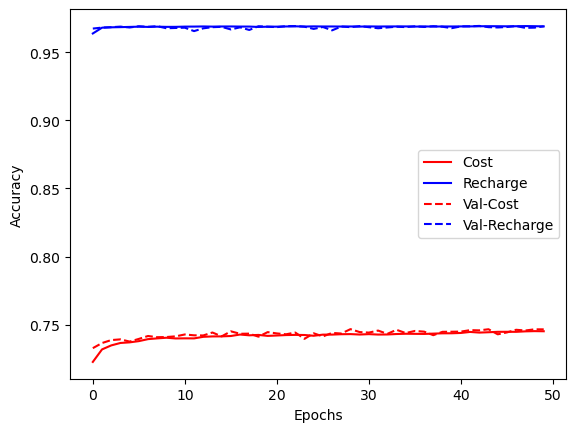

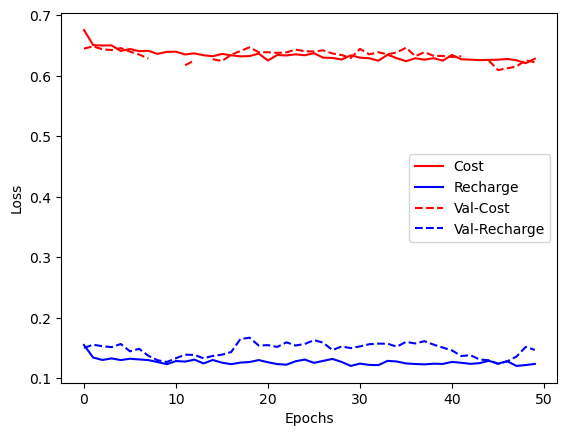

-----------消耗模型评估分值: ---------
accuracy: 0.750
ovr macro auc: 0.781
ovo macro auc: 0.826
ovr weighted auc: 0.819
ovo weighted auc: 0.836
micro precision: 0.750
macro precision: 0.654
weighted precision: 0.719
micro recall: 0.750
macro recall: 0.536
weighted recall: 0.750
-----------充值模型评估分值: ---------
accuracy: 0.970
ovr macro auc: 0.774
ovo macro auc: 0.851
ovr weighted auc: 0.846
ovo weighted auc: 0.851
micro precision: 0.970
macro precision: 0.628
weighted precision: 0.957
micro recall: 0.970
macro recall: 0.400
weighted recall: 0.970
---------------------------------------- plot and evaluate end ----------------------------------------


In [29]:
print('-'*40+" plot and evaluate begin "+'-'*40)

pred_result=model.predict(x=test_numeric_fea,verbose=1,use_multiprocessing=True)
    
plot_multitask_accuracies(history)

pred_result=np.asarray(pred_result)
predict_prob_cost=pred_result[0]
predict_prob_recharge=pred_result[1]
print("-----------消耗模型评估分值: ---------")
evaluate_score(test_cost_label,predict_prob_cost)
print("-----------充值模型评估分值: ---------")
evaluate_score(test_recharge_label,predict_prob_recharge)

print('-'*40+" plot and evaluate end "+'-'*40)


In [16]:
print(model.loss_weights.numpy())

0.27946943


In [23]:
print('-'*40+" evaluate on snow users begin "+'-'*40)
val_file='../data/validate_text_number_category_sentiments_20230301.txt'
df_no_user_val,labels_val,text_fea_val,categorical_fea_val,numeric_fea_val=process_raw_data(
    file_path=val_file,
    label_cols=label_cols,
    text_fea_cols=text_fea_cols,
    categorical_fea_cols=categorical_fea_cols,
    numeric_fea_cols=numeric_fea_cols
    )

print("df_no_user_val.shape=",df_no_user_val.shape)
print("labels_val.shape=",labels_val.shape)
print("text_fea_val.shape=",text_fea_val.shape)
print("categorical_fea_val.shape=",categorical_fea_val.shape)
print("numeric_fea_val.shape=",numeric_fea_val.shape)
print(df_no_user_val.head(1))
print('-'*40+" evaluate on snow users begin "+'-'*40)


---------------------------------------- evaluate on snow users begin ----------------------------------------
df_no_user_val.shape= (89464, 271)
labels_val.shape= (89464, 2)
text_fea_val.shape= (89464, 1)
categorical_fea_val.shape= (89464, 3)
numeric_fea_val.shape= (89464, 265)
   c_label  r_label                      problem_content  main_belong_loc1  \
0        2        2  15666066288#15666066288#15666066288               372   

   main_belong_cate2 main_city_hierarchy  free_money_avg_1d  \
0                706                  二线           0.073778   

   free_money_avg_3d  free_money_avg_7d  free_money_avg_14d  ...  \
0           0.221333           0.516444            1.032889  ...   

   m_login_counts_60d  sum_senti_score_latest_3month  \
0                   0                            2.0   

   count_senti_score_latest_3mont  avg_score_latest_3month  \
0                               4                      0.5   

   sum_senti_score_latest_6month  count_senti_score_latest_6m

In [24]:
df_numeric_fea_scale_val=process_numeric_fea(numeric_fea_val)
val_numeric_fea_scale=np.asarray(df_numeric_fea_scale_val).astype('float32')
val_cost_label=np.asarray(labels_val.values[:,0]).astype('int32')
val_recharge_label=np.asarray(labels_val.values[:,1]).astype('int32')

In [25]:
print(val_cost_label[0:10])
print(val_recharge_label[0:10])
#print(val_numeric_fea_scale[0:10])
#val_numeric_fea_scale.shape

df_numeric_fea_scale_val.isnull().values.any()

df_numeric_fea_scale_val.isnull().sum().sum()




[2 1 2 2 1 1 0 2 0 2]
[2 2 2 2 2 2 2 2 2 2]


0

In [26]:

pred_result_val=model.predict(x=val_numeric_fea_scale,verbose=1,use_multiprocessing=True)

pred_result_val=np.asarray(pred_result_val)
predict_prob_cost_val=pred_result_val[0]
predict_prob_recharge_val=pred_result_val[1]
print("-----------消耗模型评估分值: ---------")
evaluate_score(val_cost_label,predict_prob_cost_val)
print("-----------充值模型评估分值: ---------")
evaluate_score(val_recharge_label,predict_prob_recharge_val)




2796/2796 [==============================] - 3s 1ms/step
-----------消耗模型评估分值: ---------
accuracy: 0.651
ovr macro auc: 0.762
ovo macro auc: 0.794
ovr weighted auc: 0.785
ovo weighted auc: 0.801
micro precision: 0.651
macro precision: 0.647
weighted precision: 0.641
micro recall: 0.651
macro recall: 0.507
weighted recall: 0.651
-----------充值模型评估分值: ---------
accuracy: 0.972
ovr macro auc: 0.777
ovo macro auc: 0.869
ovr weighted auc: 0.868
ovo weighted auc: 0.873
micro precision: 0.972
macro precision: 0.635
weighted precision: 0.963
micro recall: 0.972
macro recall: 0.417
weighted recall: 0.972


In [28]:
print(model.loss_weights.numpy())

0.27946943
